# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
import time

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import pathlib
import urllib.request
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
pd.options.mode.chained_assignment = None
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor

In [2]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except:
    df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
df=df.drop(['DateCrawled', 'DateCreated','NumberOfPictures','PostalCode','LastSeen','RegistrationMonth'], axis=1)
df[df['VehicleType'].isna()] = 'unknown'
df[df['Gearbox'].isna()] = 'unknown'
df[df['Model'].isna()] = 'unknown'
df[df['FuelType'].isna()] = 'unknown'
df[df['NotRepaired'].isna()] = 'unknown'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  object
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  object
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  object
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  object
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   NotRepaired       354369 non-null  object
dtypes: object(10)
memory usage: 27.0+ MB


удалены столбцы с датами (DateCrawled, DateCreated, LastSeen, RegistrationMonth)
удален столбец с количеством фотографий автомобиля (NumberOfPictures) ,так как для всех объектов он равен нулю.
удален столбец с почтовым индексом владельца анкеты (PostalCode), так как он может приводить к переобучению модели.

Пропущенные значения в категориальных признаках заменены на значене неизвестно(unknown).

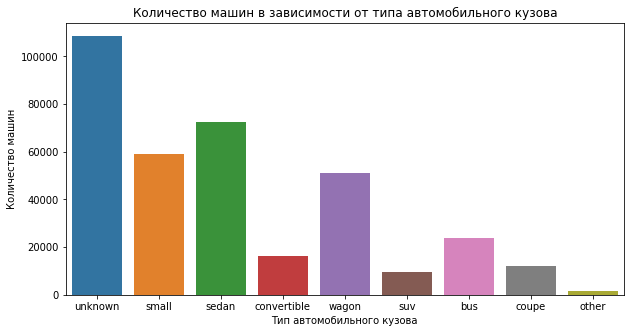

In [6]:
plt.figure(figsize=(10,5))
plt.title('Количество машин в зависимости от типа автомобильного кузова')
sns.countplot(x="VehicleType", data=df)
plt.ylabel('Количество машин')
plt.xlabel('Тип автомобильного кузова');

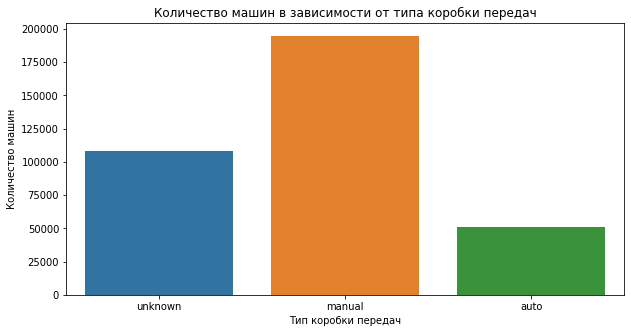

In [7]:
plt.figure(figsize=(10,5))
plt.title('Количество машин в зависимости от типа коробки передач')
sns.countplot(x="Gearbox", data=df)
plt.ylabel('Количество машин')
plt.xlabel('Тип коробки передач');

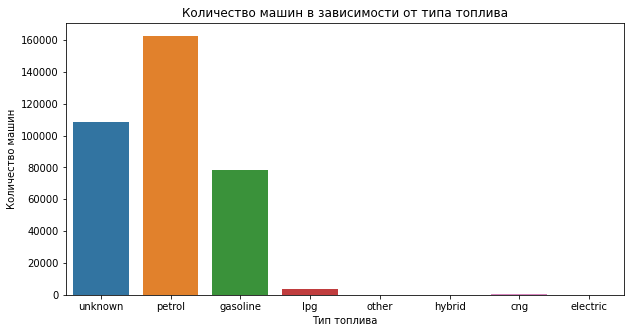

In [8]:
plt.figure(figsize=(10,5))
plt.title('Количество машин в зависимости от типа топлива')
sns.countplot(x="FuelType", data=df)
plt.ylabel('Количество машин')
plt.xlabel('Тип топлива');

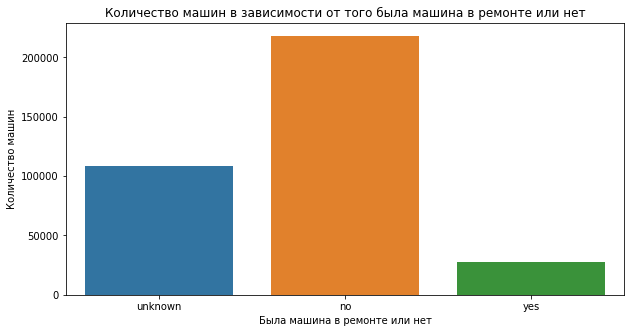

In [9]:
plt.figure(figsize=(10,5))
plt.title('Количество машин в зависимости от того была машина в ремонте или нет')
sns.countplot(x="NotRepaired", data=df)
plt.ylabel('Количество машин')
plt.xlabel('Была машина в ремонте или нет');

В основном машины не ремонтированы.

In [10]:
data = df[df['Price']!='unknown']
data['Price'] = data['Price'].astype('int')
data['RegistrationYear'] = data['RegistrationYear'].astype('int')
data['Kilometer'] = data['Kilometer'].astype('int')
data['Power'] = data['Power'].astype('int')
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245814 entries, 0 to 245813
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             245814 non-null  int32 
 1   VehicleType       245814 non-null  object
 2   RegistrationYear  245814 non-null  int32 
 3   Gearbox           245814 non-null  object
 4   Power             245814 non-null  int32 
 5   Model             245814 non-null  object
 6   Kilometer         245814 non-null  int32 
 7   FuelType          245814 non-null  object
 8   Brand             245814 non-null  object
 9   NotRepaired       245814 non-null  object
dtypes: int32(4), object(6)
memory usage: 15.0+ MB


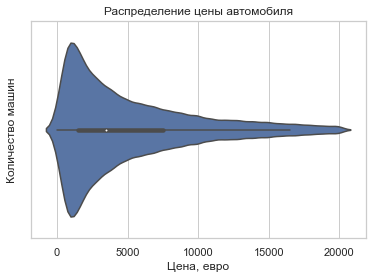

In [11]:
sns.set_theme(style="whitegrid")
plt.title('Распределение цены автомобиля')
sns.violinplot(x=data["Price"])
plt.ylabel('Количество машин')
plt.xlabel('Цена, евро');

хозяин машины  может отдать её бесплатно, поэтому Price равным нулю не будем считать за аномалию.

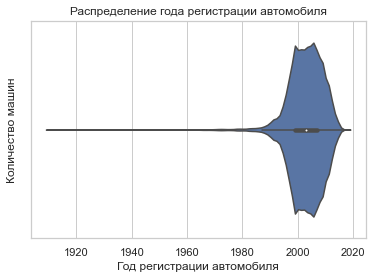

In [12]:
sns.set_theme(style="whitegrid")
plt.title('Распределение года регистрации автомобиля')
sns.violinplot(x=data["RegistrationYear"])
plt.ylabel('Количество машин')
plt.xlabel('Год регистрации автомобиля');

Машины выпущенные ранее 1970 года не учитываем.

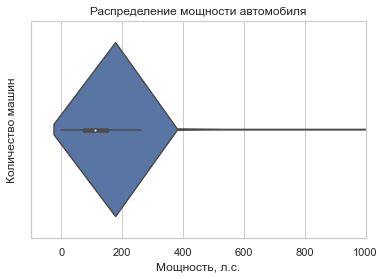

In [13]:
sns.set_theme(style="whitegrid")
plt.title('Распределение мощности автомобиля')
sns.violinplot(x=data["Power"])
plt.ylabel('Количество машин')
plt.xlabel('Мощность, л.с.')
plt.xlim(-100,1000);

Мощность равную нулю и больше 263 считаем за аномалии.

In [14]:
data = data.query('0<Power<=262.5')
data = data.query('1970<=RegistrationYear')
data = data.query('Power<263 and Power!=0')
data = data.reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230801 entries, 0 to 230800
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             230801 non-null  int32 
 1   VehicleType       230801 non-null  object
 2   RegistrationYear  230801 non-null  int32 
 3   Gearbox           230801 non-null  object
 4   Power             230801 non-null  int32 
 5   Model             230801 non-null  object
 6   Kilometer         230801 non-null  int32 
 7   FuelType          230801 non-null  object
 8   Brand             230801 non-null  object
 9   NotRepaired       230801 non-null  object
dtypes: int32(4), object(6)
memory usage: 14.1+ MB


<b> Вывод: </b> 

Была проведена предобработка данных:
    <ul>
    <li>удалены столбцы с датами (DateCrawled, DateCreated, LastSeen, RegistrationMonth)</li>
    <li>удален столбец с количеством фотографий автомобиля (NumberOfPictures) ,так как для всех объектов он равен нулю.</li>  <li>удален столбец с почтовым индексом владельца анкеты (PostalCode), так как он может приводить к переобучению модели</li>
        <li> пропущенные значения заменены на значение unknown</li>
        <li>удалены значения unknown из целевого признака (Price)</li>
        <li>изменен тип данных строк на целое число в столбцах RegistrationYear, Kilometer, Price, Power</li>
    <li> Удалены аномалии из количественных признаков</li>
</ul>


## Обучение моделей

In [15]:
categorial = ['VehicleType', 'Gearbox', 'FuelType', 'Model', 'Brand', 'NotRepaired']

In [16]:
data_ohe = pd.get_dummies(data,drop_first=True,columns=categorial)
data_ohe.head()

,Price,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,3600,2008,69,90000,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2200,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1980,50,40000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
encoder = OrdinalEncoder()
data[categorial] = encoder.fit_transform(data[categorial])
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,1500,5.0,2001,1.0,75,116.0,150000,6.0,37.0,0.0
1,3600,5.0,2008,1.0,69,101.0,90000,2.0,31.0,0.0
2,650,4.0,1995,1.0,102,11.0,150000,6.0,2.0,1.0
3,2200,1.0,2004,1.0,109,8.0,150000,6.0,25.0,0.0
4,0,4.0,1980,1.0,50,166.0,40000,6.0,37.0,0.0


Преобразованы категориальные признаки в численные техникой прямого кодирования(One-Hot Encoding) и техникой Ordinal Encoding. Так как в дальнейшем будем использовать линейные алгоритмы обучения модели, то будем использовать таблицу data_ohe.

In [18]:
df_train, df_test = train_test_split(data_ohe, test_size=0.25, random_state=12345)
features_train = df_train.drop(['Price'],axis=1)
target_train = df_train['Price']
features_test = df_test.drop(['Price'],axis=1)
target_test = df_test['Price']

Выборка разделена на обучающую и тестовую.

In [19]:
result = {}
rmse ={}
mae= {}
r2 ={}

In [20]:
start_time = time.time()
model = LinearRegression()
model.fit(features_train, target_train)
pred = model.predict(features_test)
mse = mean_squared_error(target_test, pred)
rmse['LinearRegression'] = mse**0.5
mae['LinearRegression'] = mean_absolute_error(target_test, pred)
r2['LinearRegression'] = r2_score(target_test, pred)
result['LinearRegression'] = time.time() - start_time
print("time_LinearRegression :",result['LinearRegression'])
print('RMSE_LinearRegression =',rmse['LinearRegression'])
print('MAE_LinearRegression =',mae['LinearRegression'])
print('R2_LinearRegression =',r2['LinearRegression'])

time_LinearRegression : 3.239999294281006
RMSE_LinearRegression = 2432.1150660419235
MAE_LinearRegression = 1697.9909687055185
R2_LinearRegression = 0.7240112534525778


In [ ]:
start_time = time.time()
model = DecisionTreeRegressor(max_depth=19, min_samples_split=6,random_state=12345)
model.fit(features_train, target_train)
pred = model.predict(features_test)
mse = mean_squared_error(target_test, pred)
rmse['DecisionTreeRegressor'] = mse**0.5
mae['DecisionTreeRegressor'] = mean_absolute_error(target_test, pred)
r2['DecisionTreeRegressor'] = r2_score(target_test, pred)
result['DecisionTreeRegressor'] = time.time() - start_time
print("time_DecisionTreeRegressor :",result['DecisionTreeRegressor'])
print('RMSE_DecisionTreeRegressor =',rmse['DecisionTreeRegressor'])
print('MAE_DecisionTreeRegressor =',mae['DecisionTreeRegressor'])
print('R2_DecisionTreeRegressor =',r2['DecisionTreeRegressor'])

In [ ]:
start_time = time.time()
model = LGBMRegressor(random_state=12345)
model.fit(features_train, target_train)
pred = model.predict(features_test)
mse = mean_squared_error(target_test, pred)
rmse['LGBMRegressor'] = mse**0.5
mae['LGBMRegressor'] = mean_absolute_error(target_test, pred)
r2['LGBMRegressor'] = r2_score(target_test, pred)
result['LGBMRegressor'] = time.time() - start_time
print("time_LGBMRegressor :",result['LGBMRegressor'])
print('RMSE_LGBMRegressor =',rmse['LGBMRegressor'])
print('MAE_LGBMRegressor =',mae['LGBMRegressor'])
print('R2_LGBMRegressor =',r2['LGBMRegressor'])

In [ ]:
start_time = time.time()
model = CatBoostRegressor(random_state=12345, verbose=False)
model.fit(features_train, target_train)
pred = model.predict(features_test)
mse = mean_squared_error(target_test, pred)
rmse['CatBoostRegressor'] = mse**0.5
mae['CatBoostRegressor'] = mean_absolute_error(target_test, pred)
r2['CatBoostRegressor'] = r2_score(target_test, pred)
result['CatBoostRegressor'] = time.time() - start_time
print("time_CatBoostRegressor :",result['CatBoostRegressor'])
print('RMSE_CatBoostRegressor =',rmse['CatBoostRegressor'])
print('MAE_CatBoostRegressor =',mae['CatBoostRegressor'])
print('R2_CatBoostRegressor =',r2['CatBoostRegressor'])

<b> Вывод: </b> Преобразованы категориальные признаки в численные техникой прямого кодирования(One-Hot Encoding).
Выборка разделена на обучающую и тестовую.
Обучены модели Линейная регрессия, Решающее дерево, Градиентный бустинг. Для каждой модели вычислен RMSE и время работы алгоритма.

## Анализ моделей

In [ ]:
data_result = pd.DataFrame(data=[rmse,mae,r2,result], index=['rmse','mae','r2','time'])
data_result

<b> Вывод: </b> Лучшей моделью по метрикам CatBoostRegressor, по времени - LGBMRegressor. Оптимальной моделью является LGBMRegressor.